<a href="https://colab.research.google.com/github/ErialdoDFreitas/neural-networks-implementations/blob/main/CONVOLUTIONAL_NEURAL_NETWORK/CNN_AND_MLP/Trabalho_Final_PokeDuelo_com_CNN_e_MLP_AP_Erialdo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Disciplina**: Aprendizagem Profunda - PPGCC IFCE
**Professor**: Saulo Freitas \
**Aluno**: Francisco Erialdo

#### **Tarefa**: Rede Neural Covolucional (CNN) e Rede Perceptron de Múltiplas Camadas (MLP), aplicada à criação de um Duelo Pokemon
Dataset utilizado: Sprites da pokeapi.co

## Implementação

In [ ]:
# --- 1. Instalações e Imports Necessários ---
!pip install requests pillow numpy torch torchvision scikit-image matplotlib seaborn pydrive

import requests
import os
import json
import numpy as np
import pandas as pd
import io
import time
import shutil
from PIL import Image
from tqdm.notebook import tqdm
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [ ]:
# --- 2. Definindo o dispositivo de execução (GPU ou CPU), coleta e organização dos Dados da PokeAPI ---

# Definir o dispositivo (GPU se disponível, senão CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Função para pegar os dados da API
def fetch_pokemon_data(pokemon_id):
    """Busca dados de um Pokémon específico da PokeAPI."""
    base_url = "https://pokeapi.co/api/v2/pokemon/"
    try:
        response = requests.get(f"{base_url}{pokemon_id}/")
        response.raise_for_status() # Lança um erro para status de resposta HTTP ruins
        data = response.json()

        # Extrai dados relevantes
        pokemon_info = {
            'id': data['id'],
            'name': data['name'],
            'types': [t['type']['name'] for t in data['types']],
            'attack': next((stat['base_stat'] for stat in data['stats'] if stat['stat']['name'] == 'attack'), 0),
            'special-attack': next((stat['base_stat'] for stat in data['stats'] if stat['stat']['name'] == 'special-attack'), 0),
            'sprite_url': data['sprites']['front_default'] # Sprite padrão
        }
        return pokemon_info
    except requests.exceptions.RequestException as e:
        print(f"Erro ao buscar dados do Pokémon {pokemon_id}: {e}")
        return None


# Função para fazer o download de um sprite com retries e timeout, com verificação de tipo de conteúdo.
def download_sprite(url, save_path, retries=3, delay=1):
    """Faz o download de um sprite com retries e timeout."""
    if not url:
        return None

    for attempt in range(retries):
        try:
            # Tenta baixar a imagem com um timeout
            response = requests.get(url, stream=True, timeout=10) # Timeout de 10 segundos
            response.raise_for_status() # Lança um erro para status HTTP 4xx/5xx
            content_type = response.headers.get('Content-Type', '')

            if 'image/png' not in content_type:
                print(f"Aviso: URL {url} não retornou um PNG. Content-Type: {content_type}. Tentativa {attempt+1}/{retries}.")
                # Se não for PNG, não faz sentido retentar, a menos que seja um erro temporário de Content-Type
                return None # Sai da função imediatamente se o tipo estiver errado

            img = Image.open(io.BytesIO(response.content))
            if img.mode != 'RGBA':
                img = img.convert('RGBA')
            img.save(save_path)
            return save_path # Sucesso, retorna o caminho

        except requests.exceptions.Timeout:
            print(f"Timeout ao baixar {url}. Tentativa {attempt+1}/{retries}. Retrying...")
            time.sleep(delay)
        except requests.exceptions.ConnectionError:
            print(f"Erro de conexão ao baixar {url}. Tentativa {attempt+1}/{retries}. Retrying...")
            time.sleep(delay)
        except requests.exceptions.RequestException as e:
            print(f"Erro de requisição fatal ao baixar {url}: {e}. Tentativa {attempt+1}/{retries}. Não retrying para erros HTTP.")
            return None # Erros HTTP persistentes, não retenta
        except Exception as e:
            print(f"Erro ao processar imagem de {url}: {e}. O arquivo pode estar corrompido ou não é uma imagem válida. Tentativa {attempt+1}/{retries}.")
            time.sleep(delay) # Pode ser um download parcial, retenta

    print(f"Falha ao baixar e processar {url} após {retries} tentativas.")
    return None # Falhou após todas as tentativas

# Método para coletar os dados baixados da API
def collect_all_pokemon_data(start_id, end_id, sprite_dir='pokemon_sprites'):
    """Coleta dados e baixa sprites para um intervalo de Pokémon IDs."""
    os.makedirs(sprite_dir, exist_ok=True) # Cria o diretório se não existir

    temp_pokemon_data = [] # Lista temporária para coletar dados válidos
    print(f"Coletando dados e sprites de Pokémon {start_id} a {end_id}...")
    for i in tqdm(range(start_id, end_id + 1), desc="Baixando Pokémon Data"):
        poke_data = fetch_pokemon_data(i) # Assume que fetch_pokemon_data está definida e funciona
        if poke_data: # Se os dados básicos do Pokémon foram obtidos
            sprite_filename = f"{sprite_dir}/{poke_data['id']}.png"

            # Tenta baixar o sprite e armazena o caminho se for bem-sucedido
            downloaded_path = download_sprite(poke_data['sprite_url'], sprite_filename)

            if downloaded_path: # Apenas adiciona se o sprite foi baixado e salvo com sucesso
                poke_data['sprite_path'] = downloaded_path
                temp_pokemon_data.append(poke_data)
        time.sleep(0.01) # Pequeno atraso para não sobrecarregar a API

    # --- FILTRAGEM DE POKÉMON COM SPRITES INVÁLIDOS ---
    df = pd.DataFrame(temp_pokemon_data)
    # Garante que apenas Pokémon com 'sprite_path' (ou seja, download bem-sucedido) sejam mantidos
    filtered_df = df[df['sprite_path'].notna()].copy()
    # Fazer uma cópia para evitar SettingWithCopyWarning, se for modificar o DataFrame filtrado

    return filtered_df

# Função para carregar dados dos dataframes montados
def load_df_data(train_start_id, train_end_id, test_start_id, test_end_id):
    print("Coletando dados para o conjunto de TREINAMENTO...")
    df_train_raw = collect_all_pokemon_data(train_start_id, train_end_id, sprite_dir='pokemon_sprites_train')
    # Filtra Pokémon que não tiveram sprite_path definido (download falhou) e não existe
    df_train_filtered = df_train_raw[df_train_raw['sprite_path'].notna()].copy()
    print(f"Dados de treino coletados e filtrados: {len(df_train_filtered)} Pokémons válidos.")

    print("\nColetando dados para o conjunto de TESTE...")
    df_test_raw = collect_all_pokemon_data(test_start_id, test_end_id, sprite_dir='pokemon_sprites_test')
    # Filtra Pokémon que não tiveram sprite_path definido (download falhou) e não existe
    df_test_filtered = df_test_raw[df_test_raw['sprite_path'].notna()].copy()
    print(f"Dados de teste coletados e filtrados: {len(df_test_filtered)} Pokémons válidos.")

    return df_train_filtered, df_test_filtered


# --- 3. Lógica de Vantagem de Tipo e Rotulação de Duelo ---

# Matriz de eficácia de tipos simplificada
# Multiplicadores: 2.0 = super eficaz, 0.5 = pouco eficaz, 0.0 = sem efeito, 1.0 = normal
def get_type_effectiveness():
  """ Retorna a matriz de eficácia de tipos, baseada na tabela fornecida na descrição da atividade. """
  return {
      "normal": {
          "normal": 1.0, "fire": 1.0, "water": 1.0, "grass": 1.0, "electric": 1.0, "ice": 1.0,
          "fighting": 1.0, "poison": 1.0, "ground": 1.0, "flying": 1.0, "psychic": 1.0,
          "bug": 1.0, "rock": 0.5, "ghost": 0.0, "dragon": 1.0, "steel": 0.5, "fairy": 1.0
      },
      "fire": {
          "normal": 1.0, "fire": 0.5, "water": 0.5, "grass": 2.0, "electric": 1.0, "ice": 2.0,
          "fighting": 1.0, "poison": 1.0, "ground": 1.0, "flying": 1.0, "psychic": 1.0,
          "bug": 2.0, "rock": 0.5, "ghost": 1.0, "dragon": 0.5, "steel": 2.0, "fairy": 1.0
      },
      "water": {
          "normal": 1.0, "fire": 2.0, "water": 0.5, "grass": 0.5, "electric": 1.0, "ice": 1.0,
          "fighting": 1.0, "poison": 1.0, "ground": 2.0, "flying": 1.0, "psychic": 1.0,
          "bug": 1.0, "rock": 2.0, "ghost": 1.0, "dragon": 0.5, "steel": 1.0, "fairy": 1.0
      },
      "grass": {
          "normal": 1.0, "fire": 0.5, "water": 2.0, "grass": 0.5, "electric": 1.0, "ice": 1.0,
          "fighting": 1.0, "poison": 0.5, "ground": 2.0, "flying": 0.5, "psychic": 1.0,
          "bug": 0.5, "rock": 2.0, "ghost": 1.0, "dragon": 0.5, "steel": 0.5, "fairy": 1.0
      },
      "electric": {
          "normal": 1.0, "fire": 1.0, "water": 2.0, "grass": 0.5, "electric": 0.5, "ice": 1.0,
          "fighting": 1.0, "poison": 1.0, "ground": 0.0, "flying": 2.0, "psychic": 1.0,
          "bug": 1.0, "rock": 1.0, "ghost": 1.0, "dragon": 0.5, "steel": 1.0, "fairy": 1.0
      },
      "ice": {
          "normal": 1.0, "fire": 0.5, "water": 0.5, "grass": 2.0, "electric": 1.0, "ice": 0.5,
          "fighting": 1.0, "poison": 1.0, "ground": 2.0, "flying": 2.0, "psychic": 1.0,
          "bug": 1.0, "rock": 1.0, "ghost": 1.0, "dragon": 2.0, "steel": 0.5, "fairy": 1.0
      },
      "fighting": {
          "normal": 2.0, "fire": 1.0, "water": 1.0, "grass": 1.0, "electric": 1.0, "ice": 2.0,
          "fighting": 1.0, "poison": 0.5, "ground": 1.0, "flying": 0.5, "psychic": 0.5,
          "bug": 0.5, "rock": 2.0, "ghost": 0.0, "dragon": 1.0, "steel": 2.0, "fairy": 0.5
      },
      "poison": {
          "normal": 1.0, "fire": 1.0, "water": 1.0, "grass": 2.0, "electric": 1.0, "ice": 1.0,
          "fighting": 1.0, "poison": 0.5, "ground": 0.5, "flying": 1.0, "psychic": 1.0,
          "bug": 1.0, "rock": 0.5, "ghost": 0.5, "dragon": 1.0, "steel": 0.0, "fairy": 2.0
      },
      "ground": {
          "normal": 1.0, "fire": 2.0, "water": 1.0, "grass": 0.5, "electric": 2.0, "ice": 1.0,
          "fighting": 1.0, "poison": 2.0, "ground": 1.0, "flying": 0.0, "psychic": 1.0,
          "bug": 0.5, "rock": 2.0, "ghost": 1.0, "dragon": 1.0, "steel": 2.0, "fairy": 1.0
      },
      "flying": {
          "normal": 1.0, "fire": 1.0, "water": 1.0, "grass": 2.0, "electric": 0.5, "ice": 1.0,
          "fighting": 2.0, "poison": 1.0, "ground": 1.0, "flying": 1.0, "psychic": 1.0,
          "bug": 2.0, "rock": 0.5, "ghost": 1.0, "dragon": 1.0, "steel": 0.5, "fairy": 1.0
      },
      "psychic": {
          "normal": 1.0, "fire": 1.0, "water": 1.0, "grass": 1.0, "electric": 1.0, "ice": 1.0,
          "fighting": 2.0, "poison": 2.0, "ground": 1.0, "flying": 1.0, "psychic": 0.5,
          "bug": 1.0, "rock": 1.0, "ghost": 1.0, "dragon": 1.0, "steel": 0.5, "fairy": 1.0
      },
      "bug": {
          "normal": 1.0, "fire": 0.5, "water": 1.0, "grass": 2.0, "electric": 1.0, "ice": 1.0,
          "fighting": 0.5, "poison": 0.5, "ground": 1.0, "flying": 0.5, "psychic": 2.0,
          "bug": 1.0, "rock": 1.0, "ghost": 0.5, "dragon": 1.0, "steel": 0.5, "fairy": 0.5
      },
      "rock": {
          "normal": 1.0, "fire": 2.0, "water": 1.0, "grass": 1.0, "electric": 1.0, "ice": 2.0,
          "fighting": 0.5, "poison": 1.0, "ground": 0.5, "flying": 2.0, "psychic": 1.0,
          "bug": 2.0, "rock": 1.0, "ghost": 1.0, "dragon": 1.0, "steel": 0.5, "fairy": 1.0
      },
      "ghost": {
          "normal": 0.0, "fire": 1.0, "water": 1.0, "grass": 1.0, "electric": 1.0, "ice": 1.0,
          "fighting": 1.0, "poison": 1.0, "ground": 1.0, "flying": 1.0, "psychic": 2.0,
          "bug": 1.0, "rock": 1.0, "ghost": 2.0, "dragon": 1.0, "steel": 1.0, "fairy": 1.0
      },
      "dragon": {
          "normal": 1.0, "fire": 1.0, "water": 1.0, "grass": 1.0, "electric": 1.0, "ice": 1.0,
          "fighting": 1.0, "poison": 1.0, "ground": 1.0, "flying": 1.0, "psychic": 1.0,
          "bug": 1.0, "rock": 1.0, "ghost": 1.0, "dragon": 2.0, "steel": 0.5, "fairy": 0.0
      },
      "steel": {
          "normal": 1.0, "fire": 0.5, "water": 0.5, "grass": 1.0, "electric": 0.5, "ice": 2.0,
          "fighting": 1.0, "poison": 1.0, "ground": 1.0, "flying": 1.0, "psychic": 1.0,
          "bug": 1.0, "rock": 2.0, "ghost": 1.0, "dragon": 1.0, "steel": 0.5, "fairy": 2.0
      },
      "fairy": {
          "normal": 1.0, "fire": 0.5, "water": 1.0, "grass": 1.0, "electric": 1.0, "ice": 1.0,
          "fighting": 2.0, "poison": 0.5, "ground": 1.0, "flying": 1.0, "psychic": 1.0,
          "bug": 1.0, "rock": 1.0, "ghost": 1.0, "dragon": 2.0, "steel": 0.5, "fairy": 1.0
      }
  }

# Função de combinação das efetividades dos pokemons
def get_combined_effectiveness(attacker_types, defender_types):
    ''' Calcula a eficácia combinada de ataque de um Pokémon (ou seus tipos)
      contra os tipos de defesa de outro Pokémon. '''
    if not attacker_types or not defender_types:
        return 1.0 # Caso base ou erro

    total_effectiveness = 1.0
    # Para cada tipo do atacante, considera a eficácia contra CADA tipo do defensor
    # e combina multiplicando.
    # Esta é uma simplificação, pois um Pokémon geralmente usa UM ataque de UM tipo.
    # Nesse caso, está sendo usada uma abordagem onde o melhor ataque (maior multiplicador) é o que prevalece
    # e é aplicado contra os tipos do defensor.

    max_attacker_effectiveness = 0.0
    TYPE_EFFECTIVENESS = get_type_effectiveness()
    for atk_type in attacker_types:
        current_attacker_effectiveness = 1.0
        for def_type in defender_types:
            # Pega a eficácia do tipo do atacante contra o tipo do defensor
            effectiveness_val = TYPE_EFFECTIVENESS.get(atk_type, {}).get(def_type, 1.0)
            current_attacker_effectiveness *= effectiveness_val
        max_attacker_effectiveness = max(max_attacker_effectiveness, current_attacker_effectiveness)

    return max_attacker_effectiveness

# Função para definir as tipos de vantagens entre os pokemons do duelo
def type_advantage(p1_types, p2_types):
    """
    Determina a vantagem de tipo entre dois Pokémon.
    Retorna:
    +1 se P1 tem vantagem significativa
    -1 se P2 tem vantagem significativa
    0 para empate ou vantagem neutra
    """
    p1_to_p2_eff = get_combined_effectiveness(p1_types, p2_types)
    p2_to_p1_eff = get_combined_effectiveness(p2_types, p1_types)

    if p1_to_p2_eff >= 2.0 and p2_to_p1_eff < 1.0: # P1 super eficaz e P2 pouco eficaz
        return 1
    elif p1_to_p2_eff > 1.0 and p2_to_p1_eff <= 1.0: # P1 super eficaz e P2 normal/pouco
        return 1
    elif p2_to_p1_eff >= 2.0 and p1_to_p2_eff < 1.0: # P2 super eficaz e P1 pouco eficaz
        return -1
    elif p2_to_p1_eff > 1.0 and p1_to_p2_eff <= 1.0: # P2 super eficaz e P1 normal/pouco # Corrected p1_to_p1_eff to p1_to_p2_eff
        return -1
    else:
        return 0 # Caso contrário, empate ou vantagem não tão clara

# Função de geração dos rótulos dos duelos
def calculate_duel_label(p1_data, p2_data):
    """
    Gera o rótulo do duelo (0: P1 perde, 1: Empate, 2: P1 vence)
    baseado na lógica de tipo e poder.
    """
    advantage_score = type_advantage(p1_data['types'], p2_data['types'])
    power_diff = (p1_data['attack'] + p1_data['special-attack']) - \
                 (p2_data['attack'] + p2_data['special-attack'])

    # Normaliza a diferença de poder para uma escala comparável com a vantagem de tipo
    # Uma forma simples é usar np.sign() como sugerido.
    # Podemos ponderar o impacto do power_diff.

    # Adaptação da sugestão:
    if advantage_score + np.sign(power_diff) >= 1:
        return 2  # p1 vence
    elif advantage_score + np.sign(power_diff) <= -1:
        return 0  # p1 perde
    else:
        return 1  # empate


# --- 4. Custom Dataset para Pares de Imagens ---
class PokemonDuelDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.pokemon_ids = dataframe['id'].tolist()
        self.id_to_data = dataframe.set_index('id').to_dict('index')

        # Gerar todos os pares possíveis e seus rótulos
        self.duel_pairs = []
        for i in tqdm(range(len(self.pokemon_ids)), desc="Gerando pares de duelos"):
            p1_id = self.pokemon_ids[i]
            p1_data = self.id_to_data[p1_id]

            for j in range(len(self.pokemon_ids)):
                p2_id = self.pokemon_ids[j]
                # Evitar duelos de Pokémon consigo mesmos, a menos que seja intencional (aqui vamos evitar)
                if p1_id == p2_id:
                    continue

                p2_data = self.id_to_data[p2_id]
                label = calculate_duel_label(p1_data, p2_data)
                self.duel_pairs.append({
                    'p1_id': p1_id,
                    'p2_id': p2_id,
                    'p1_sprite_path': p1_data['sprite_path'],
                    'p2_sprite_path': p2_data['sprite_path'],
                    'label': label,
                    'p1_types': p1_data['types'], # Adicionar tipos para debugging/inspeção
                    'p2_types': p2_data['types']
                })
        print(f"Total de pares de duelos gerados: {len(self.duel_pairs)}")


    def __len__(self):
        return len(self.duel_pairs)

    def __getitem__(self, idx):
        duel_info = self.duel_pairs[idx]

        # Carregar imagens
        img1 = Image.open(duel_info['p1_sprite_path']).convert('RGBA')
        img2 = Image.open(duel_info['p2_sprite_path']).convert('RGBA')

        # Aplicar transformações
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        # Opcional: Adicionar dados numéricos (e.g., tipo_advantage_score)
        # Se você quiser passar isso para a MLP final, precisaria calcular aqui
        # ou na função `calculate_duel_label` e armazenar no `duel_info`.
        # Por enquanto, focamos apenas nos embeddings das imagens.

        label = torch.tensor(duel_info['label'], dtype=torch.long) # CrossEntropyLoss espera long

        return img1, img2, label


# --- 5. Definição da Arquitetura das Redes para treinamento do Modelo ---
# Classe que define a Rede Convolucional para reconhecimento dos pokemons do Duelo
class CNNEncoder(nn.Module):
    """
    CNN base para extrair embeddings de sprites de Pokémon.
    """
    def __init__(self, input_channels=4, embedding_dim=128, image_size=(96, 96)):
        super(CNNEncoder, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # Usando Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 96 -> 48

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 48 -> 24

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 24 -> 12
        )

        # Calculando dinamicamenteo tamanho da camada 'flattern'
        self._dummy_input_size = self._get_conv_output((input_channels, image_size[0], image_size[1]))
        self.fc = nn.Linear(self._dummy_input_size, embedding_dim)

    def _get_conv_output(self, shape):
        """Calcula o tamanho da saída após as camadas convolucionais."""
        bs = 1
        input = torch.autograd.Variable(torch.rand(bs, *shape))
        output_feat = self.features(input)
        num_features = output_feat.data.view(bs, -1).size(1)
        return num_features

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc(x)
        return x

# Classe que define o Classificador do Duelo
class DuelClassifier(nn.Module):
    """
    Combina embeddings dos Pokémon e classifica o resultado do duelo.
    """
    def __init__(self, embedding_dim, output_classes=3, image_size=(96, 96)):
        super(DuelClassifier, self).__init__()
        self.encoder = CNNEncoder(embedding_dim=embedding_dim, image_size=image_size)

        # O input para a MLP será: embedding1 + embedding2 + abs(embedding1 - embedding2)
        # Isso significa 3 * embedding_dim
        mlp_input_dim = embedding_dim * 3

        self.mlp = nn.Sequential(
            nn.Linear(mlp_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5), # Regularização para evitar overfitting
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, output_classes)
            # CrossEntropyLoss já espera logits, então não deve-se usar Softmax aqui
        )

    def forward(self, img1, img2):
        embed1 = self.encoder(img1)
        embed2 = self.encoder(img2)

        # Combinação dos embeddings
        # concat([embed1, embed2, abs(embed1 - embed2)])
        combined_features = torch.cat([embed1, embed2, torch.abs(embed1 - embed2)], dim=1)

        output = self.mlp(combined_features)
        return output


# --- 6. Treinamento e visualização das métricas do treinamento do Modelo ---
# --- Funções Auxiliares para Checkpoints com PyDrive ---

# def get_or_create_folder(drive_service, folder_name, parent_id=None):
#     """Verifica se uma pasta existe e a cria caso não exista. Retorna o ID."""
#     query = f"title = '{folder_name}' and trashed = false"
#     if parent_id:
#         query += f" and '{parent_id}' in parents"

#     file_list = drive_service.ListFile({'q': query}).GetList()

#     if file_list:
#         return file_list[0]['id']
#     else:
#         folder = drive_service.CreateFile({
#             'title': folder_name,
#             'mimeType': 'application/vnd.google-apps.folder',
#             'parents': [{'id': parent_id}] if parent_id else []
#         })
#         folder.Upload()
#         print(f"Pasta '{folder_name}' criada no Google Drive.")
#         return folder['id']

# -- Lógica de Verificação de Ambiente e Configuração de Caminhos --
def setup_environment():
    """
    Verifica o ambiente de execução e configura os caminhos dos checkpoints.
    Esta lógica é a mais robusta para diferenciar Colab, Kaggle e Local.
    !! LEMBRANDO QUE NO SE FOR EXECUTAR NO KAGGLE,SE QUERER SUBIR OS CHECKPOINTS COMO DATASETS,
    É NECESSÁRIO LEMBRAR DE REMOVÉ-LOS CASO VÁ INICIAR UM NOVO TREINAMENTO !!
    """
    if os.path.exists('/kaggle'):
        print("\nAmbiente detectado: Kaggle")
        checkpoint_dir_save = "/kaggle/working"
        checkpoint_dir_load = "/kaggle/input/pokeduelo-checkpoints"
        return checkpoint_dir_save, checkpoint_dir_load, "kaggle"
    elif 'google.colab' in sys.modules:
        print("\nAmbiente detectado: Google Colab")
        from google.colab import drive
        drive.mount('/content/drive')
        checkpoint_dir = "/content/drive/My Drive/Colab Notebooks/IFCE/PPGCC/Duelo_Pokemon"
        os.makedirs(checkpoint_dir, exist_ok=True)
        return checkpoint_dir, None, "colab"
    else:
        print("\nAmbiente detectado: Local (ou Outro)")
        checkpoint_dir = "checkpoints_duelo_pokemon"
        os.makedirs(checkpoint_dir, exist_ok=True)
        return checkpoint_dir, None, "local"

# --- Funções Auxiliares para Checkpoints ---
def save_checkpoint(model, optimizer, epoch, val_loss, val_accuracy, train_losses,
                    train_accuracies, val_losses, val_accuracies, file_path):
    """
    Salva o estado do modelo, otimizador e métricas de controle em um arquivo.
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
    }, file_path)
    print(f"Checkpoint salvo em: {file_path}")

def load_checkpoint(model, optimizer, file_path, input_dir=None):
    """
    Carrega o estado do modelo de um arquivo no diretório de trabalho.
    Se não encontrar, tenta carregar de um diretório de input (Dataset).
    """
    if os.path.exists(file_path):
        checkpoint = torch.load(file_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Checkpoint carregado com sucesso do arquivo: {file_path}")
        return (checkpoint['epoch'],
                checkpoint['val_loss'],
                checkpoint['val_accuracy'],
                checkpoint['train_losses'],
                checkpoint['train_accuracies'],
                checkpoint['val_losses'],
                checkpoint['val_accuracies']
               )

    # Lógica específica para Kaggle: se o arquivo não estiver no working dir,
    # tenta copiá-lo do diretório de input do Dataset
    if input_dir:
        input_file_path = os.path.join(input_dir, os.path.basename(file_path))
        if os.path.exists(input_file_path):
            print(f"Checkpoint encontrado no Dataset. Copiando para {file_path}...")
            shutil.copyfile(input_file_path, file_path)
            checkpoint = torch.load(file_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            if optimizer is not None:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

            print(f"Checkpoint carregado com sucesso do arquivo: {file_path}")
            return (checkpoint['epoch'],
                    checkpoint['val_loss'],
                    checkpoint['val_accuracy'],
                    checkpoint['train_losses'],
                    checkpoint['train_accuracies'],
                    checkpoint['val_losses'],
                    checkpoint['val_accuracies']
                   )

    return None


# Função principal, para executar o treinamento do Modelo
def train_model(model, train_loader, val_loader, criterion, optimizer,
                best_val_loss, best_val_accuracy,
                num_epochs, start_epoch,
                best_checkpoint_path, last_checkpoint_path,
                train_losses, train_accuracies,
                val_losses, val_accuracies):
    """
    Treina o modelo e avalia no conjunto de validação a cada época,
    registrando o histórico de loss e accuracy.
    """
    model.train() # Coloca o modelo em modo de treinamento

    for epoch in range(start_epoch, num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Treinamento
        for img1, img2, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = 100 * correct_train / total_train

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.2f}%")

        # Avaliação no conjunto de validação
        if val_loader:
            print("Executando avaliação do modelo a partir do conjunto de validação...")
            model.eval() # Coloca o modelo em modo de avaliação
            val_correct = 0
            val_total = 0
            val_current_loss = 0.0
            with torch.no_grad():
                for img1, img2, labels in val_loader:
                    img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
                    outputs = model(img1, img2)
                    loss = criterion(outputs, labels)
                    val_current_loss += loss.item() * labels.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            epoch_val_acc = 100 * val_correct / val_total
            epoch_val_loss = val_current_loss / val_total
            val_accuracies.append(epoch_val_acc)
            val_losses.append(epoch_val_loss)
            print(f" Val. Loss: {epoch_val_loss:.4f} Acc.: {epoch_val_acc:.2f}%")

            # Implementando Lógica de Checkpoints de treinamento do modelo
            # Salva o checkpoint a partir da melhor acurácia de validação atual
            # OU a partir da melhor taxa de loss (TALVEZ não seja recomendável usar essa abordagem,
            # mas por questões peculiares da evolução do modelo, seguir por esse caminho)
            # Pode-se testar o uso da métrica de loss como fator principal para salvar o estado do treinamento
            # if epoch_val_acc > best_val_accuracy:
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                print(f"Nova melhor (menor) loss de validação: {best_val_loss:.2f}%. Salvando Checkpoint...")
                save_checkpoint(model, optimizer, epoch + 1, best_val_loss, epoch_val_acc, train_losses, train_accuracies,
                                val_losses, val_accuracies, best_checkpoint_path)

            elif epoch_val_acc > best_val_accuracy:
                best_val_accuracy = epoch_val_acc
                print(f"Nova melhor acurácia de validação: {best_val_accuracy:.2f}%. Salvando Checkpoint...")
                save_checkpoint(model, optimizer, epoch + 1, epoch_val_loss, best_val_accuracy, train_losses, train_accuracies,
                                val_losses, val_accuracies, best_checkpoint_path)

            # Salva um checkpoint a cada duas épocas, para servir como uma espécie de backup do treinamento
            if (epoch + 1) % 2 == 0:
                print(f"Salvando checkpoint do último estado na época {epoch + 1}...")
                save_checkpoint(model, optimizer, epoch + 1, epoch_val_loss, epoch_val_acc, train_losses, train_accuracies,
                                val_losses, val_accuracies, last_checkpoint_path)

            model.train() # Retorna ao modo de treinamento

        else: # Se não houver val_loader, preenche com None para manter o mesmo formato
            val_losses.append(None)
            val_accuracies.append(None)

    # Retorna o histórico completo
    return train_losses, train_accuracies, val_losses, val_accuracies

# Função para plot da Matriz de Confusão e Repport de Classificação, respectivamente
def plot_cm_and_classific_report(all_labels, all_predictions, classes):
    # Relatório de Classificação
    print("\n--- Relatório de Classificação no Conjunto de Teste ---")
    print(classification_report(all_labels, all_predictions, target_names=["Derrota", "Empate", "Vitória"]))

    # Matriz de Confusão
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Derrota", "Empate", "Vitória"],
                yticklabels=["Derrota", "Empate", "Vitória"])
    plt.xlabel("Previsto")
    plt.ylabel("Verdadeiro")
    plt.title("Matriz de Confusão")
    plt.show()

# Função para plot de curvas de Loss e Acurácia, respectivamente
def plot_training_curves(train_losses, train_accuracies, val_losses=None, val_accuracies=None):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    # Plot da Curva de Perda
    plt.subplot(1, 2, 1) # 1 linha, 2 colunas, 1º gráfico
    plt.plot(epochs, train_losses, 'r-o', label='Loss de Treinamento', markersize=4)
    if val_losses and all(v is not None for v in val_losses):
        plt.plot(epochs, val_losses, 'y-o', label='Loss de Validação', markersize=4)
    plt.title('Curva de Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot da Curva de Acurácia
    plt.subplot(1, 2, 2) # 1 linha, 2 colunas, 2º gráfico
    plt.plot(epochs, train_accuracies, 'b-o', label='Acurácia de Treinamento', markersize=4)
    if val_accuracies and all(v is not None for v in val_accuracies):
        plt.plot(epochs, val_accuracies, 'g-o', label='Acurácia de Validação', markersize=4)
    plt.title('Curva de Acurácia')
    plt.xlabel('Época')
    plt.ylabel('Acurácia (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Ajusta o layout para evitar sobreposição
    plt.show()


# --- 7. Função de Avaliação Final (com Coerência Semântica) ---
def evaluate_final_model(model, test_loader, criteria_cases):
    """
    Avalia o modelo no conjunto de teste e verifica a coerência semântica.
    """
    model.eval() # Modo de avaliação
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Mostrando Report de Classificação, e também a Matriz de Confusão
    plot_cm_and_classific_report(all_labels, all_predictions, classes=[0, 1, 2])

    # Avaliação de Coerência Semântica
    print("\n--- Avaliação de Coerência Semântica (Casos Específicos) ---")
    model.eval()
    correct_semantic_cases = 0

    # Criar um dicionário de dados de Pokémon por ID para fácil acesso
    test_pokemon_data = test_loader.dataset.dataframe.set_index('id').to_dict('index')

    for case_num, case_info in criteria_cases.items():
        p1_name = case_info['Pokémon 1']
        p2_name = case_info['Pokémon 2']
        expected_category_label = case_info['Categoria']

        # Encontrar IDs dos Pokémon pelos nomes (supondo que os nomes sejam únicos no dataset)
        p1_data = next((p for p in test_pokemon_data.values() if p['name'].lower() == p1_name.lower()), None)
        p2_data = next((p for p in test_pokemon_data.values() if p['name'].lower() == p2_name.lower()), None)

        if not p1_data or not p2_data:
            print(f"Aviso: Pokémon '{p1_name}' ou '{p2_name}' não encontrados no dataset de teste. Pulando caso {case_num}.")
            continue

        # Carregar e transformar as imagens
        img1_path = p1_data['sprite_path']
        img2_path = p2_data['sprite_path']

        transform = test_loader.dataset.transform # Usar as mesmas transformações do test_loader
        img1 = transform(Image.open(img1_path).convert('RGBA')).unsqueeze(0).to(device)
        img2 = transform(Image.open(img2_path).convert('RGBA')).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img1, img2)
            _, predicted_label = torch.max(output.data, 1)
            predicted_category = ["Derrota", "Empate", "Vitória"][predicted_label.item()]

        # Mapear o rótulo esperado para 0, 1, 2
        # 'Vitória (1º Pokémon vence)' -> 2
        # 'Empate (poderes equivalentes)' -> 1
        # 'Derrota (2º Pokémon vence)' -> 0
        expected_label_map = {
            "Pikachu vence": 2, "Charizard perde": 0, "Venusaur perde": 0, "Machamp perde": 0,
            "Golem perde": 0, "Scyther perde": 0, "Jigglypuff perde": 0, "Electabuzz perde (sem efeito)": 0,
            "Magikarp perde": 0, "Caterpie perde": 0, "Farfetch’d perde": 0, "Ditto perde (na prática)": 0,
            "Metapod perde": 0, "Snorlax perde": 0, "Dragonite perde": 0
        } # Dicionário ajustado para para mapear as frases diretamente, referente ao mapeamento de 'Expectativa "Lógica Pokémon"' para 0, 1, 2.

        expected_output_label = expected_label_map.get(case_info['Expectativa "Lógica Pokémon"'], -1) # -1 para casos não mapeados

        is_correct = (predicted_label.item() == expected_output_label)
        if is_correct:
            correct_semantic_cases += 1

        print(f"Caso {case_num}: {p1_name} vs {p2_name}")
        # print(f"  - Expectativa Lógica: {case_info['Expectativa \"Lógica Pokémon\"']}")
        logical_spectation_label = case_info['Expectativa "Lógica Pokémon"']
        print(f"  - Expectativa Lógica: {logical_spectation_label}")
        print(f"  - Previsão do Modelo: {predicted_category} (Label: {predicted_label.item()})")
        print(f"  - Resultado: {'✅ Correto' if is_correct else '❌ Incorreto'}")
        print("-" * 30)

    total_semantic_cases = len(criteria_cases)
    print(f"\nPontuação de Coerência Semântica: {correct_semantic_cases}/{total_semantic_cases} "
          f"({(correct_semantic_cases / total_semantic_cases) * 100:.2f}%)")



Using device: cuda


Dados já coletados. Carregando...
Dados de treino reais: 690 Pokémon. Dados de validação: 173 Pokémon.

Preparando Datasets e DataLoaders...


Gerando pares de duelos:   0%|          | 0/690 [00:00<?, ?it/s]

Total de pares de duelos gerados: 475410


Gerando pares de duelos:   0%|          | 0/173 [00:00<?, ?it/s]

Total de pares de duelos gerados: 29756


Gerando pares de duelos:   0%|          | 0/151 [00:00<?, ?it/s]

Total de pares de duelos gerados: 22650
Datasets e DataLoaders prontos.

Total de parâmetros treináveis no modelo: 2585251

Contagens de cada classe no conjunto de treino: tensor([190505,  94400, 190505])
Pesos de perda por classe: tensor([0.7466, 1.5067, 0.7466])
Pesos de perda atualizados: tensor([0.7466, 5.2736, 0.7466])
Pesos de perda re-normalizados: tensor([0.1103, 0.7793, 0.1103])

Ambiente detectado: Kaggle
Checkpoint encontrado no Dataset. Copiando para /kaggle/working/last_model_checkpoint.pth...
Checkpoint carregado com sucesso do arquivo: /kaggle/working/last_model_checkpoint.pth

Checkpoint encontrado (último estado). Carregando...

Treinamento já completo. Pulando a etapa de treinamento.

--- Iniciando Avaliação Final ---
Checkpoint encontrado no Dataset. Copiando para /kaggle/working/best_model_checkpoint.pth...
Checkpoint carregado com sucesso do arquivo: /kaggle/working/best_model_checkpoint.pth

Avaliação final será feita com o melhor modelo salvo.

--- Relatório de C

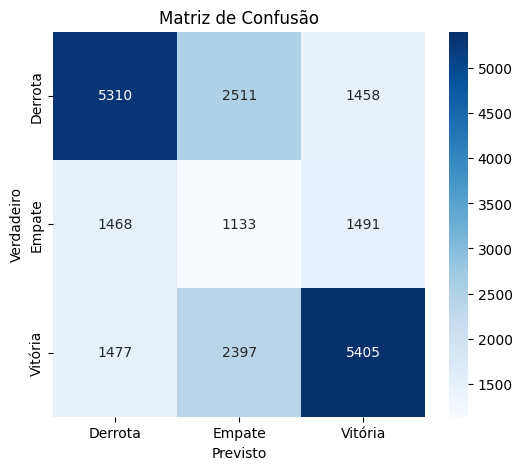


--- Avaliação de Coerência Semântica (Casos Específicos) ---
Caso 1: Pikachu vs Gyarados
  - Expectativa Lógica: Pikachu vence
  - Previsão do Modelo: Derrota (Label: 0)
  - Resultado: ❌ Incorreto
------------------------------
Caso 2: Charizard vs Blastoise
  - Expectativa Lógica: Charizard perde
  - Previsão do Modelo: Vitória (Label: 2)
  - Resultado: ❌ Incorreto
------------------------------
Caso 3: Venusaur vs Charizard
  - Expectativa Lógica: Venusaur perde
  - Previsão do Modelo: Derrota (Label: 0)
  - Resultado: ✅ Correto
------------------------------
Caso 4: Machamp vs Alakazam
  - Expectativa Lógica: Machamp perde
  - Previsão do Modelo: Vitória (Label: 2)
  - Resultado: ❌ Incorreto
------------------------------
Caso 5: Golem vs Blastoise
  - Expectativa Lógica: Golem perde
  - Previsão do Modelo: Vitória (Label: 2)
  - Resultado: ❌ Incorreto
------------------------------
Caso 6: Scyther vs Charizard
  - Expectativa Lógica: Scyther perde
  - Previsão do Modelo: Derrota (

In [ ]:
# 8. --- Execução Principal ---
def main():
    # -- Passo 1: Coleta de Dados --
    # IDs para treino (2ª geração em diante)

    train_start_id = 152
    train_end_id = 1015

    # IDs para teste (1ª geração)
    test_start_id = 1
    test_end_id = 151

    # Carregando os dados de Treinamento e Teste
    global df_train, df_test
    if ('df_train' in globals() and not df_train.empty) and ('df_test' in globals() and not df_test.empty):
      print("Dados já coletados. Carregando...")
    else:
      print("Dataframes não encontrados ou vazios. Coletando dados da API...")
      df_train, df_test = load_df_data(train_start_id, train_end_id, test_start_id, test_end_id)

    # -- Dividir df_train em treino e validação
    # Usando 80% do df_train para treino e 20% para validação
    train_df_actual, val_df_actual = train_test_split(
        df_train, test_size=0.2, random_state=42
    )
    print(f"Dados de treino reais: {len(train_df_actual)} Pokémon. Dados de validação: {len(val_df_actual)} Pokémon.")


    # -- Passo 2: Configuração do Dataset e DataLoader --
    # As imagens da PokeAPI podem variar de tamanho. Aqui está sendo redimensionado para um tamanho fixo (ex: 64x64)
    # e normalizar os pixels para o intervalo [0, 1].
    image_size = (96, 96)
    transform = transforms.Compose([
        transforms.Resize(image_size), # Redimensiona para um tamanho comum para sprites
        transforms.ToTensor(),       # Converte PIL Image para Tensor (0-1)
        # Normalização (se os valores dos pixels já estiverem entre 0 e 1, sem normalização padrão)
        # transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5, 0.5]) # Exemplo para RGBA
    ])

    print("\nPreparando Datasets e DataLoaders...")
    train_dataset = PokemonDuelDataset(train_df_actual, transform=transform)
    val_dataset = PokemonDuelDataset(val_df_actual, transform=transform)
    test_dataset = PokemonDuelDataset(df_test, transform=transform)

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    print("Datasets e DataLoaders prontos.")


    # -- Passo 3: Inicialização do Modelo, Otimizador e Função de Perda --
    embedding_dim = 128 # Dimensão do embedding da CNN
    model = DuelClassifier(embedding_dim=embedding_dim, image_size=image_size).to(device)

    # Número de parâmetros treináveis
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal de parâmetros treináveis no modelo: {num_params}")

    # -- Implementando Weighted Cross-Entropy Loss
    # - Calcular contagens de cada classe no train_dataset
    label_counts = torch.bincount(torch.tensor([d['label'] for d in train_dataset.duel_pairs]))
    print(f"\nContagens de cada classe no conjunto de treino: {label_counts}")
    # Calcular pesos de forma inversa proporcional à frequência (ajustando conforme necessário)
    # Por exemplo, 1.0 / frequência da classe
    labels_weights = 1.0 / label_counts.float()
    labels_weights = labels_weights / labels_weights.sum() * 3 # Normaliza e ajusta para que a soma seja o num de classes
    print(f"Pesos de perda por classe: {labels_weights}")

    # - Aumentando o peso da classe empate
    empate_boost_factor = 3.5
    labels_weights[1] *= empate_boost_factor
    print(f"Pesos de perda atualizados: {labels_weights}")

    # - Pode-se tentar Re-normalizar (não obrigatório, mas boa prática)
    labels_weights = labels_weights / labels_weights.sum()
    print(f"Pesos de perda re-normalizados: {labels_weights}")

    # Definindo o Loss Criterion e Optimizer a serem utilizados
    criterion = nn.CrossEntropyLoss(weight=labels_weights.to(device)) # Para classificação multiclasse
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4) # Adicionando L2 Regularization


    # -- Passo 4: Treinamento do Modelo --

    # -- Faz a verificação do arquivo de checkpoints e carrega os dados dele

    # 1. Obter ou criar a pasta de checkpoints no Google Drive
    # checkpoint_folder_name = "IFCE/PPGCC/Duelo_Pokemon"
    # folder_id = get_or_create_folder(drive_service, checkpoint_folder_name)
    # # 2. Definição dos nomes dos arquivos dos checkpoints
    # best_checkpoint_name = "best_model_checkpoint.pth"
    # last_checkpoint_name = "last_model_checkpoint.pth"

    # Define as variáveis de acordo com o ambiente
    checkpoint_dir, input_dir, environment_type = setup_environment()

    # Define os caminhos dos arquivos de checkpoint
    best_checkpoint_path = os.path.join(checkpoint_dir, "best_model_checkpoint.pth")
    last_checkpoint_path = os.path.join(checkpoint_dir, "last_model_checkpoint.pth")

    # Os comandos abaixo irão forçar um novo treinamento na próxima execução.
    if os.path.exists(last_checkpoint_path):
        os.remove(last_checkpoint_path)
    if os.path.exists(best_checkpoint_path):
        os.remove(best_checkpoint_path)

    # - Inicializa as variáveis para execução do treinamento
    num_epochs = 20
    start_epoch = 0
    best_val_accuracy = 0.0
    best_val_loss = float('inf')
    train_accuracies, train_losses = [], []
    val_accuracies, val_losses = [], []

    # Lógica de carregamento: prioriza o último checkpoint, mas usa o melhor como fallback
    checkpoint_data = load_checkpoint(model, optimizer, last_checkpoint_path, input_dir=input_dir)
    if checkpoint_data:
        print("\nCheckpoint encontrado (último estado). Carregando...")
        start_epoch, best_val_loss, best_val_accuracy, checkp_train_losses, checkp_train_accuracies, checkp_val_losses, checkp_val_accuracies \
            = checkpoint_data
        train_losses = checkp_train_losses
        train_accuracies = checkp_train_accuracies
        val_losses = checkp_val_losses
        val_accuracies = checkp_val_accuracies

    else:
        checkpoint_data = load_checkpoint(model, optimizer, best_checkpoint_path, input_dir=input_dir)
        if checkpoint_data:
            print("\nCheckpoint encontrado ('melhor' estado - menor loss). Carregando...")
            start_epoch, best_val_loss, best_val_accuracy, checkp_train_losses, checkp_train_accuracies, checkp_val_losses, checkp_val_accuracies \
                = checkpoint_data
            train_losses = checkp_train_losses
            train_accuracies = checkp_train_accuracies
            val_losses = checkp_val_losses
            val_accuracies = checkp_val_accuracies
        else:
            print("\nNenhum checkpoint encontrado. Iniciando treinamento do modelo do zero.")

    if start_epoch < num_epochs:
        print(f"\nIniciando treinamento por {num_epochs} épocas...")
        new_train_losses, new_train_accuracies, new_val_losses, new_val_accuracies = \
            train_model(model, train_loader, val_loader, criterion, optimizer,
                        best_val_loss, best_val_accuracy, num_epochs, start_epoch,
                        best_checkpoint_path, last_checkpoint_path,
                        train_losses, train_accuracies,
                        val_losses, val_accuracies)

        # Plotar as curvas de treinamento (loss e acurácia) do modelo
        print("\nPlotando curvas de treinamento...")
        plot_training_curves(new_train_losses, new_train_accuracies, new_val_losses, new_val_accuracies)

    else:
       print(f"\nTreinamento já completo. Pulando a etapa de treinamento.")


    # -- Passo 5: Avaliação Final do modelo --
    print("\n--- Iniciando Avaliação Final ---")

    # Dicionário de dados baseado na tabela de casos para avaliação subjetiva
    criteria_cases = {
        1: {'Pokémon 1': 'Pikachu', 'Tipo(s) 1': 'Elétrico', 'Pokémon 2': 'Gyarados', 'Tipo(s) 2': 'Água/Voador', 'Expectativa "Lógica Pokémon"': 'Pikachu vence', 'Categoria': 'Clássico', 'Justificativa': 'Elétrico é 4x eficaz contra Água/Voador'},
        2: {'Pokémon 1': 'Charizard', 'Tipo(s) 1': 'Fogo/Voador', 'Pokémon 2': 'Blastoise', 'Tipo(s) 2': 'Água', 'Expectativa "Lógica Pokémon"': 'Charizard perde', 'Categoria': 'Clássico', 'Justificativa': 'Água é forte contra Fogo'},
        3: {'Pokémon 1': 'Venusaur', 'Tipo(s) 1': 'Planta/Veneno', 'Pokémon 2': 'Charizard', 'Tipo(s) 2': 'Fogo/Voador', 'Expectativa "Lógica Pokémon"': 'Venusaur perde', 'Categoria': 'Clássico', 'Justificativa': 'Fogo é forte contra Planta'},
        4: {'Pokémon 1': 'Machamp', 'Tipo(s) 1': 'Lutador', 'Pokémon 2': 'Alakazam', 'Tipo(s) 2': 'Psíquico', 'Expectativa "Lógica Pokémon"': 'Machamp perde', 'Categoria': 'Clássico', 'Justificativa': 'Psíquico é forte contra Lutador'},
        5: {'Pokémon 1': 'Golem', 'Tipo(s) 1': 'Pedra/Terra', 'Pokémon 2': 'Blastoise', 'Tipo(s) 2': 'Água', 'Expectativa "Lógica Pokémon"': 'Golem perde', 'Categoria': 'Clássico', 'Justificativa': 'Água é forte contra Terra/Pedra'},
        6: {'Pokémon 1': 'Scyther', 'Tipo(s) 1': 'Inseto/Voador', 'Pokémon 2': 'Charizard', 'Tipo(s) 2': 'Fogo/Voador', 'Expectativa "Lógica Pokémon"': 'Scyther perde', 'Categoria': 'Clássico', 'Justificativa': 'Fogo é forte contra Inseto'},
        7: {'Pokémon 1': 'Jigglypuff', 'Tipo(s) 1': 'Normal/Fada', 'Pokémon 2': 'Gengar', 'Tipo(s) 2': 'Fantasma/Veneno', 'Expectativa "Lógica Pokémon"': 'Jigglypuff perde', 'Categoria': 'Clássico', 'Justificativa': 'Fantasma imune a Normal, forte contra Fada'},
        8: {'Pokémon 1': 'Electabuzz', 'Tipo(s) 1': 'Elétrico', 'Pokémon 2': 'Rhydon', 'Tipo(s) 2': 'Terra/Pedra', 'Expectativa "Lógica Pokémon"': 'Electabuzz perde (sem efeito)', 'Categoria': 'Clássico', 'Justificativa': 'Elétrico não afeta tipo Terra'},
        9: {'Pokémon 1': 'Magikarp', 'Tipo(s) 1': 'Água', 'Pokémon 2': 'Machamp', 'Tipo(s) 2': 'Lutador', 'Expectativa "Lógica Pokémon"': 'Magikarp perde', 'Categoria': 'Absurdo', 'Justificativa': 'Magikarp é notoriamente fraco'},
        10: {'Pokémon 1': 'Caterpie', 'Tipo(s) 1': 'Inseto', 'Pokémon 2': 'Arcanine', 'Tipo(s) 2': 'Fogo', 'Expectativa "Lógica Pokémon"': 'Caterpie perde', 'Categoria': 'Absurdo', 'Justificativa': 'Inseto fraco contra Fogo, Caterpie tem stats baixíssimos'},
        11: {'Pokémon 1': 'Farfetchd', 'Tipo(s) 1': 'Normal/Voador', 'Pokémon 2': 'Zapdos', 'Tipo(s) 2': 'Elétrico/Voador', 'Expectativa "Lógica Pokémon"': 'Farfetch’d perde', 'Categoria': 'Absurdo', 'Justificativa': 'Diferença massiva de stats e fama'},
        12: {'Pokémon 1': 'Ditto', 'Tipo(s) 1': 'Normal', 'Pokémon 2': 'Dragonite', 'Tipo(s) 2': 'Dragão/Voador', 'Expectativa "Lógica Pokémon"': 'Ditto perde (na prática)', 'Categoria': 'Absurdo', 'Justificativa': 'Ditto precisa de transformação para lutar bem'},
        13: {'Pokémon 1': 'Metapod', 'Tipo(s) 1': 'Inseto', 'Pokémon 2': 'Charizard', 'Tipo(s) T2': 'Fogo/Voador', 'Expectativa "Lógica Pokémon"': 'Metapod perde', 'Categoria': 'Absurdo', 'Justificativa': 'Metapod só usa Harden, fraco vs Fogo'},
        14: {'Pokémon 1': 'Snorlax', 'Tipo(s) 1': 'Normal', 'Pokémon 2': 'Hitmonlee', 'Tipo(s) 2': 'Lutador', 'Expectativa "Lógica Pokémon"': 'Snorlax perde', 'Categoria': 'Clássico', 'Justificativa': 'Lutador é eficaz contra Normal'},
        15: {'Pokémon 1': 'Dragonite', 'Tipo(s) 1': 'Dragão/Voador', 'Pokémon 2': 'Articuno', 'Tipo(s) 2': 'Gelo/Voador', 'Expectativa "Lógica Pokémon"': 'Dragonite perde', 'Categoria': 'Clássico', 'Justificativa': 'Gelo é 4x eficaz contra Dragão/Voador'}
    }

    # Criando uma instância para o modelo final, que foi treinado e depois carregado via checkpoint
    final_model = DuelClassifier(embedding_dim=embedding_dim, image_size=image_size)
    final_model.to(device)

    # Carrega os pesos do melhor checkpoint
    best_checkpoint_data = load_checkpoint(final_model, optimizer=None, file_path=best_checkpoint_path, input_dir=input_dir)

    # Avalia o Modelo final
    # evaluate_final_model(final_model, test_loader, criteria_cases)
    # Agora, a avaliação só é feita se o melhor checkpoint foi carregado
    if best_checkpoint_data:
      print("\nAvaliação final será feita com o melhor modelo salvo.")
      evaluate_final_model(final_model, test_loader, criteria_cases)
    else:
      print("Não foi possível carregar o melhor modelo para avaliação.")


if __name__ == "__main__":
    main()